# PARAFAC Decomposition Example 
### (aka CP / CANDECOMP / PARAFAC)

Идея тензорного разложения заключается в представлении исходного тензора X в виде суммы триад. Минимальное количество триад, на которые можно разложить тензор, назы- вается рангом тензора. Псевдо-ранг - это кол-во триад, которое получилось по итогу разложения (и это не всегда ранг, мы можем приблизить исходный тензор до какой-то допустимой для задачи точности, а остальное уйдет в тензор ошибок).

PARAFAC - по сути, частный случай разложения Таккера с единичным core-тензором G. И, в трехмерном случае, вместо суммы произведений маленького тензора на 3 матрицы, получается сумма произведений 3-х векторов (потому, что на супер диагонали G будут единицы).

### 3х-мерный случай:

\begin{align}
\mathcal{\underline X} = \sum_{r=1}^R a_{r} * b_{r} * c_{r} + {\underline E}
\end{align}

где $\mathcal{{\underline X} - исходный \space тензор}$,
$\mathcal{a_r, \space b_r, \space c_r - вектора}$,
$\mathcal{* - кронекерово \space произведение}$,
$\mathcal{{\underline E} - тензор \space ошибок}$,
$\mathcal{{R} - псевдо-ранг \space тензора \space (количество \space слагаемых).}$,

### D-мерный случай:
Для d-мерного тензора разложение будет выглядеть следующим образом:

$\mathcal{\underline X} \in \mathbb{R}^{d}$ :

\begin{align}
\mathcal{\underline X}_{(i_{1}, ... , i_{d})} = \sum_{r=1}^R A_{(i_{1},\space r)} * ... * A_{(i_{d},\space r)} + {\underline E}
\end{align}

Для понимания, воспользуемся разложением по определению:
\begin{align}
\mathcal{\underline X} = \sum_{i,j,k≠0} e_{i} * e_{j} * e_{k} * {\underline X(i,j,k)}
\end{align}
где $\mathcal{e_i, \space e_j, \space e_k - единичные \space вектора}$

In [6]:
import math
import numpy as np

# decomp_rank - кол-во слагаемых
# в соответствии с вышеуказанной формулой, мы должны вернуть: 
# разложение в виде векторов
# тензор ошибок нашего разложения

class Triades:
    def __init__(self, A, B, C, tensor_shape, row, slice):
        self.A = A
        self.B = B
        self.C = C
        self.tensor_shape = tensor_shape
        self.row = row
        self.slice = slice


def get_factor_decomp_3d(tensor, row, slice):
    A = tensor[row, :, slice] # i-я строка k-го среза
    B = np.zeros_like(tensor[:, 0, slice]) # вектор из нулей
    B[row] = 1 # установили единицу в нужной строке для умножения
    C = np.zeros_like(tensor[0, 0, :]) # вектор из нулей
    C[slice] = 1 # установили единицу в нужном срезе для умножения

    triade = Triades(A=A, B=B, C=C, tensor_shape=tensor.shape, row=row, slice=slice)
    # print(triade.A)
    return triade

def get_factor_product_3d(triade):
    factor_tensor = np.zeros(triade.tensor_shape)
    factor_tensor[triade.slice, triade.row, :] = triade.A
    return factor_tensor
    

def get_diff(tensor_1, tensor_2):
    return tensor_1 - tensor_2

def get_summ(triades_list):
    tensor_list = []
    for i in range(len(triades_list)):
        tensor_list.append(get_factor_product_3d(triades_list[i]))
    if len(tensor_list) < 1:
        return []
    summ = np.zeros_like(tensor_list[0])
    for i in range(len(tensor_list)):
        summ = summ + tensor_list[i]
    return summ


def parafac_3d(data_tensor, decomp_rank):
    I, J, K = data_tensor.shape
    factor_list = []
    error_tensor = np.zeros_like(data_tensor)
    print("data_tensor shape:", data_tensor.shape)

    if (decomp_rank):
        K = decomp_rank

    # заполняем массив факторов:
    for i in range(I):
        for k in range(K):
            factor_list.append(get_factor_decomp_3d(data_tensor, i, k))
    
    error_tensor = get_diff(data_tensor, get_summ(factor_list))

    return factor_list, error_tensor

    

Здесь возьмем простую функцию (сумма индексов), чтобы можно было визуально оценить, что мы получаем при разложении:

In [7]:
def myMatrixIndexSumFunc(i, j, k):
    return i + j + k + 3

N1 = N2 = N3 = 2
T = np.fromfunction(myMatrixIndexSumFunc, [N1,N2,N3])

# здесь нормальное разложение, по кол-ву элементов:
factor_list, error_tensor = parafac_3d(T, 2)
#print("factor_list:")
#print(factor_list)
print("error_tensor:")
print(error_tensor)
print("data_tensor:")
print(T)

# здесь кол-во слагаемых меньше, чем нужно, поэтому тензор ошибок будет ненулевым:
factor_list, error_tensor = parafac_3d(T, 1) 
#print("factor_list:")
#print(factor_list)
print("error_tensor:")
print(error_tensor)
print("data_tensor:")
print(T)

data_tensor shape: (2, 2, 2)
error_tensor:
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
data_tensor:
[[[3. 4.]
  [4. 5.]]

 [[4. 5.]
  [5. 6.]]]
data_tensor shape: (2, 2, 2)
error_tensor:
[[[0. 0.]
  [0. 0.]]

 [[4. 5.]
  [5. 6.]]]
data_tensor:
[[[3. 4.]
  [4. 5.]]

 [[4. 5.]
  [5. 6.]]]


Идея разложения в PARAFAC / CANDECOMP (ALS):
1. Инициализируем тензор чем-нибудь с известныым разложением (случайным образом) $\mathcal{\underline X} = \sum_{r=1}^R a_{r} * b_{r} * c_{r}$
2. Фиксируем все значения ($\mathcal b_{r} , c_{r}$), кроме выбранного ($\mathcal a_{r}$)
3. Решаем для него линейную задачу ALS (Aternating Least Squares, наименьших квадратов)
4. Повторяем решение задачи ALS последовательно для всех оставшихся значений
5. Повторяем процедуру, пока не достагнем критерия остановки (обычно точность или кол-во итераций)

Для реальных задач можно воспользоваться библиотечной реализацией parafac. Например, из tensorLy:

In [5]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac

T = np.fromfunction(myMatrixIndexSumFunc, [N1,N2,N3])
test2 = parafac(T, 2)

print(test2.weights)
print(test2.factors)

[1. 1.]
[array([[ 8.5940423 , -0.24768112],
       [10.08277184, -0.14092481]]), array([[0.66508732, 1.72292692],
       [0.78026222, 0.98087872]]), array([[0.66813138, 1.93681297],
       [0.78379646, 1.10328796]])]


Ниже пример использования 

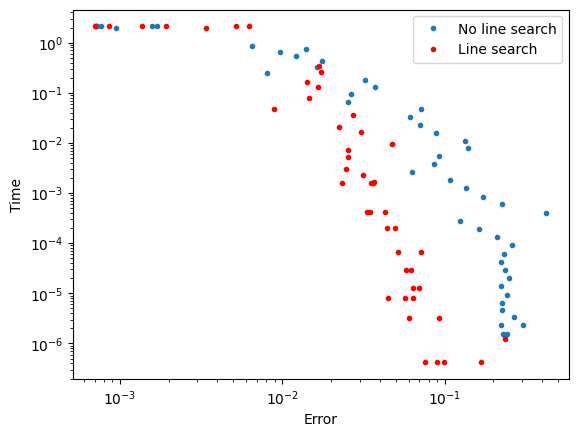

In [1]:
import matplotlib.pyplot as plt

from time import time
import numpy as np
import tensorly as tl
from tensorly.random import random_cp
from tensorly.decomposition import CP, parafac

tol = np.logspace(-1, -9) # толерантность
err = np.empty_like(tol) # ошибка разложения без ЛП
err_line_search = np.empty_like(tol) # ошибка разложения с ЛП
tt = np.empty_like(tol) # время без ЛП
tt_line_search = np.empty_like(tol) # время для ЛП

# задаем какой-то поизвольный тензор
tensor = random_cp((10, 10, 10), 3, random_state=1234, full=True)

# Получаем разложение с высокой точностью для сравнения
fac = parafac(tensor, rank=3, n_iter_max=2000000, tol=1.0e-15, linesearch=True)
err_min = tl.norm(tl.cp_to_tensor(fac) - tensor)

# PARAFAC без линейного поиска с подсчетом времени
for index, item in enumerate(tol):
    start = time()
    cp = CP(rank=3, n_iter_max=2000000, tol=item, linesearch=False)
    fac = cp.fit_transform(tensor)
    tt[index] = time() - start
    # считаем ошибку
    err[index] = tl.norm(tl.cp_to_tensor(fac) - tensor)

# PARAFAC с линейным поиском и подсчетом времени
for index, item in enumerate(tol):
    start = time()
    cp = CP(rank=3, n_iter_max=2000000, tol=item, linesearch=True)
    fac_line_search = cp.fit_transform(tensor)
    tt_line_search[index] = time() - start
    # Считаем ошибку
    err_line_search[index] = tl.norm(tl.cp_to_tensor(fac_line_search) - tensor)

# строим график для обоих вариантов
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(tt, err - err_min, '.', label="С линейным поиском")
ax.loglog(tt_line_search, err_line_search - err_min, '.r', label="Без линейного поиска")
ax.legend()
ax.set_ylabel("Time")
ax.set_xlabel("Error")

plt.show()